In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# both = glob.glob('./data/*.{}'.format('csv'))

# df_og = pd.concat([pd.read_csv(f) for f in both ], ignore_index=True)

df_batch_cur = pd.read_csv("data/rams_batch_cur_20250325.csv")
df_batch_cur.head()

start_date = "2024-05-01"
end_date = "2025-03-31"

df_trans = pd.read_csv('data/transaction_fact_20250325.csv')
df_trans["transaction_date"] = pd.to_datetime(df_trans["transaction_date"])
df_trans["transaction_month"] = df_trans["transaction_date"].dt.month

df_trans = df_trans[(df_trans['transaction_date'] >= start_date) & (df_trans['transaction_date'] <= end_date)]
df_trans = df_trans[(df_trans['transaction_type'] == "SALE") & (df_trans['transaction_amt'] >= 0)]

df_worldtrans = pd.read_csv("data/wrld_stor_tran_fact_20250325.csv")
df_worldtrans["transaction_date"] = pd.to_datetime(df_worldtrans["transaction_date"])
df_worldtrans["transaction_month"] = df_worldtrans["transaction_date"].dt.month

df_worldtrans = df_worldtrans[(df_worldtrans['transaction_date'] >= start_date) & (df_worldtrans['transaction_date'] <= end_date)]
df_worldtrans = df_worldtrans[(df_worldtrans['transaction_type'] == "SALE") & (df_worldtrans['transaction_amt'] >= 0)]

df_statement = pd.read_csv("data/statement_fact_20250325.csv")
df_statement = df_statement[['current_account_nbr', 'billing_cycle_date']]
df_statement['billing_cycle_date'] = pd.to_datetime(df_statement["billing_cycle_date"])
df_statement['billing_day'] = df_statement["billing_cycle_date"].dt.day


In [76]:
df_statement['cycle_day'] = df_statement.groupby('current_account_nbr')['billing_day'].transform(lambda x: pd.Series.mode(x)[0])
df_statement = df_statement[['current_account_nbr', 'cycle_day']]
df_statement = df_statement.drop_duplicates()

df_trans = pd.merge(df_trans, df_statement, on='current_account_nbr', how = 'inner')

df_worldtrans = pd.merge(df_worldtrans, df_statement, on='current_account_nbr', how = 'inner')
df_trans.head()

,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,payment_type,transaction_return_cnt,transaction_sale_cnt,product_amt,product_qty,...,curr_markup_fee,fcr_amount,fcr_flag,fcr_rate_of_exchange,frgn_curr_code,frgn_tran_amt,us_equiv_amt,posting_date,transaction_month,cycle_day
0,X7jfKh6xrPAB8Tx6,SALE,253,2024-06-05,15.78,NaN,0,1,NaN,NaN,...,0.0,NaN,NaN,NaN,840,15.78,0.0,2024-06-06,6,11
1,yntD77AZDylS48Q4,SALE,253,2024-06-19,14.85,NaN,0,1,NaN,NaN,...,0.0,NaN,NaN,NaN,840,14.85,0.0,2024-06-20,6,25
2,LIJPI0sK28Pa7fX2,SALE,253,2024-06-26,136.16,NaN,0,1,NaN,NaN,...,0.0,NaN,NaN,NaN,840,136.16,0.0,2024-06-27,6,15
3,CMAr5Apxwdzpvoze,SALE,253,2024-08-15,8.74,NaN,0,1,NaN,NaN,...,0.0,NaN,NaN,NaN,840,8.74,0.0,2024-08-16,8,30
4,eJSfTCGPvJulGzd3,SALE,253,2024-08-17,26.65,NaN,0,1,NaN,NaN,...,0.0,NaN,NaN,NaN,840,26.65,0.0,2024-08-18,8,20


In [77]:
df_trans['cycle'] = df_trans.transaction_month + (df_trans.transaction_date.dt.day > df_trans.cycle_day)
df_trans.loc[df_trans['cycle'] == 13, 'cycle'] = 1

df_worldtrans['cycle'] = df_worldtrans.transaction_month + (df_worldtrans.transaction_date.dt.day > df_worldtrans.cycle_day)
df_worldtrans.loc[df_worldtrans['cycle'] == 13, 'cycle'] = 1


df_trans[['current_account_nbr', 'cycle_day', 'transaction_date', 'cycle']].sort_values('transaction_date')

,current_account_nbr,cycle_day,transaction_date,cycle
198656,NmhT4HaS9gZctVJD,26,2024-05-01,5
239706,85DGdL8S5ZfaSJ7f,9,2024-05-01,5
15002,Tyrxaq5byhsu7lJg,2,2024-05-01,5
46186,9Sl7YhKhtmoAeZQ9,30,2024-05-01,5
65016,9yqfetwzyftgM9p3,3,2024-05-01,5
...,...,...,...,...
85966,eZ0DJl5CgzquXkyH,23,2025-03-24,4
77699,U3quHmWEZPPFKyIY,24,2025-03-24,3
86172,edqKl2I8yKGHvNu8,26,2025-03-24,3
81757,y2MF6gpN1SCe8ueX,2,2025-03-24,4


In [78]:
df_trans_grouped = df_trans.groupby(['current_account_nbr', 'transaction_type', 'cycle', 'first_purchase_ind', 'frgn_curr_code'])
df_monthly_trans = df_trans_grouped['transaction_amt'].sum().reset_index()
df_monthly_trans = df_monthly_trans.sort_values(by=['current_account_nbr', 'cycle', 'first_purchase_ind', 'frgn_curr_code'], ascending=[True, True, True, True])
df_monthly_trans.to_csv('transactions.csv', index = False)
df_monthly_trans.head()

,current_account_nbr,transaction_type,cycle,first_purchase_ind,frgn_curr_code,transaction_amt
0,00iP5U82D8XwVQ9G,SALE,1,N,840,494.19
1,00iP5U82D8XwVQ9G,SALE,2,N,840,371.90
2,00iP5U82D8XwVQ9G,SALE,3,N,840,395.59
3,00iP5U82D8XwVQ9G,SALE,5,N,840,184.56
4,00iP5U82D8XwVQ9G,SALE,6,N,840,176.19


In [79]:
codes = set(df_worldtrans.frgn_curr_code)

In [80]:
df_exchange = pd.read_csv('currencyexchange.csv').dropna()
df_exchange.Number = df_exchange.Number.astype(int)
code_to_symbol = df_exchange.set_index("Number")["Code"].to_dict()
code_to_symbol = {k : v for k, v in code_to_symbol.items() if (str(k) in codes)}
# code_to_symbol

In [81]:
df_exchange_rates = pd.read_csv("rates.csv")
df_exchange_rates = df_exchange_rates.dropna()
# df_exchange_rates
exchange_rates = df_exchange_rates[["Currency", "USD per unit"]].set_index("Currency")["USD per unit"].to_dict()
code_to_rate = {code : exchange_rates[code_to_symbol[code]] for code in code_to_symbol}
# code_to_rate

In [82]:
df_worldtrans_grouped = df_worldtrans.groupby(['current_account_nbr', 'transaction_type', 'cycle', 'first_purchase_ind', 'frgn_curr_code'])
df_monthly_worldtrans = df_worldtrans_grouped['transaction_amt'].sum().reset_index()
df_monthly_worldtrans = df_monthly_worldtrans.sort_values(by=['current_account_nbr', 'cycle', 'first_purchase_ind', 'frgn_curr_code'], ascending=[True, True, True, True])
df_monthly_worldtrans.to_csv('transactions.csv', index = False)
df_monthly_worldtrans.head()

,current_account_nbr,transaction_type,cycle,first_purchase_ind,frgn_curr_code,transaction_amt
0,02WRVV8yusgcZWLW,SALE,2,N,840,499.28
1,02WRVV8yusgcZWLW,SALE,3,N,840,5119.56
2,02WRVV8yusgcZWLW,SALE,4,N,840,884.46
3,033o9yHYen3xoz6k,SALE,1,N,840,2317.69
4,033o9yHYen3xoz6k,SALE,2,N,840,1711.48


In [83]:
us_conversion = []
for i, row in df_monthly_worldtrans.iterrows():
    if row['frgn_curr_code'] in code_to_rate.keys():
        us_conversion.append(code_to_rate[row['frgn_curr_code']]*row['transaction_amt'])
    else:
        us_conversion.append(row['transaction_amt'])
df_monthly_worldtrans['us_conversion'] = us_conversion
df_monthly_worldtrans.head()

df_converted_worldtrans = df_monthly_worldtrans.groupby(['current_account_nbr', 'transaction_type', 'cycle', 'first_purchase_ind'])
df_converted_worldtrans = df_converted_worldtrans['us_conversion'].sum().reset_index()
df_converted_worldtrans = df_converted_worldtrans.sort_values(by=['current_account_nbr', 'cycle', 'first_purchase_ind'], ascending=[True, True, True])
df_converted_worldtrans.to_csv('converted_world_trans.csv', index = False)
df_converted_worldtrans[df_converted_worldtrans['current_account_nbr'] == "959MfurVBEcDwopY"]

,current_account_nbr,transaction_type,cycle,first_purchase_ind,us_conversion
5854,959MfurVBEcDwopY,SALE,1,N,799.14
5855,959MfurVBEcDwopY,SALE,2,N,1486.79
5856,959MfurVBEcDwopY,SALE,3,N,930.83
5857,959MfurVBEcDwopY,SALE,4,N,913.14
5858,959MfurVBEcDwopY,SALE,5,N,333.41
5859,959MfurVBEcDwopY,SALE,6,N,1247.54
5860,959MfurVBEcDwopY,SALE,7,N,1452.15
5861,959MfurVBEcDwopY,SALE,8,N,4528.46
5862,959MfurVBEcDwopY,SALE,9,N,962.39
5863,959MfurVBEcDwopY,SALE,10,N,4947.05


In [84]:
df_monthly_trans[df_monthly_trans['current_account_nbr'] == "959MfurVBEcDwopY"]

,current_account_nbr,transaction_type,cycle,first_purchase_ind,frgn_curr_code,transaction_amt
9489,959MfurVBEcDwopY,SALE,1,N,840,207.07
9490,959MfurVBEcDwopY,SALE,2,N,840,152.78
9491,959MfurVBEcDwopY,SALE,3,N,840,231.18
9492,959MfurVBEcDwopY,SALE,4,N,840,68.83
9493,959MfurVBEcDwopY,SALE,5,N,840,18.19
9494,959MfurVBEcDwopY,SALE,6,N,840,155.27
9495,959MfurVBEcDwopY,SALE,7,N,840,162.27
9496,959MfurVBEcDwopY,SALE,8,N,840,112.26
9497,959MfurVBEcDwopY,SALE,9,N,840,46.32
9498,959MfurVBEcDwopY,SALE,10,N,840,63.32


In [85]:
df_total_monthly = pd.concat([df_converted_worldtrans, df_monthly_trans])
df_total_monthly = df_total_monthly.fillna(0)
df_total_monthly['total_sales'] = df_total_monthly['transaction_amt'] + df_total_monthly['us_conversion']
df_total_monthly = df_total_monthly.groupby(['current_account_nbr', 'transaction_type', 'cycle', 'first_purchase_ind'])
df_total_monthly = df_total_monthly['total_sales'].sum().reset_index()
df_total_monthly[df_total_monthly['current_account_nbr'] == "959MfurVBEcDwopY"]

,current_account_nbr,transaction_type,cycle,first_purchase_ind,total_sales
10741,959MfurVBEcDwopY,SALE,1,N,1006.21
10742,959MfurVBEcDwopY,SALE,2,N,1639.57
10743,959MfurVBEcDwopY,SALE,3,N,1162.01
10744,959MfurVBEcDwopY,SALE,4,N,981.97
10745,959MfurVBEcDwopY,SALE,5,N,351.60
10746,959MfurVBEcDwopY,SALE,6,N,1402.81
10747,959MfurVBEcDwopY,SALE,7,N,1614.42
10748,959MfurVBEcDwopY,SALE,8,N,4640.72
10749,959MfurVBEcDwopY,SALE,9,N,1008.71
10750,959MfurVBEcDwopY,SALE,10,N,5010.37


In [86]:
import pandas as pd
df_batch_cur = pd.read_csv("data/rams_batch_cur_20250325.csv")
# df_batch_cur["rb_new_bhv_scr"].value_counts()

In [87]:
df_batch_cur['cu_processing_date'] = pd.to_datetime(df_batch_cur['cu_processing_date'])

df_batch_cur = df_batch_cur[(df_batch_cur['cu_processing_date'].dt.month == 3) & (df_batch_cur['cu_processing_date'].dt.year == 2025)]
df_batch_cur = df_batch_cur[['cu_account_nbr', 'ca_avg_utilz_lst_6_mnths', 'ca_avg_utilz_lst_3_mnths', 'ca_current_utilz']]
df_batch_cur.rename(columns={'cu_account_nbr': 'current_account_nbr'}, inplace=True)
df_batch_cur.head()

,current_account_nbr,ca_avg_utilz_lst_6_mnths,ca_avg_utilz_lst_3_mnths,ca_current_utilz
4,35VRb2UTGapQk6wE,7,7,16
21,HvbkDVIeXnrTN9cv,0,0,0
38,3RYOfGg3jSd5gaUn,24,0,0
52,FdwjCtthRzKK88wo,13,8,7
66,1oo6ImIWeHL2SMaT,0,0,0


In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_pivot = df_total_monthly.pivot_table(
    index='current_account_nbr', 
    columns='cycle', 
    values='total_sales', 
    aggfunc='sum'  
)

colnames = [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
# Rename columns to indicate cycle numbers
df_pivot.columns = [f'{int(colnames[col-1])}' for col in df_pivot.columns]

# Reset index to make it a standard DataFrame
df_pivot = df_pivot.reset_index()

df_pivot = pd.merge(df_pivot, df_batch_cur, on='current_account_nbr', how = 'inner')

df_pivot = df_pivot.fillna(0)

df_pivot = df_pivot.drop(['11', '12'], axis = 1)

df_pivot.to_csv('df_pivot.csv', index = False)
df_pivot


,current_account_nbr,8,9,10,1,2,3,4,5,6,7,ca_avg_utilz_lst_6_mnths,ca_avg_utilz_lst_3_mnths,ca_current_utilz
0,00oyr3QppAzjLws4,26.74,30.03,0.00,89.03,85.59,150.04,0.00,0.00,0.00,188.05,90,90,87
1,02WRVV8yusgcZWLW,0.00,499.28,5697.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26,21,39
2,033o9yHYen3xoz6k,3275.30,1817.53,2181.16,1410.31,1357.57,1758.56,1724.38,2013.77,3017.06,1925.55,15,14,16
3,034bM166vNmgLiIA,30.00,126.24,30.00,0.00,0.00,1041.28,30.00,488.01,570.12,119.27,69,71,70
4,03cqv0gFjEIiQG0x,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,46,45,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9340,zyZhjzJwhpOgSvmc,873.83,903.01,647.68,286.92,864.11,597.69,299.52,764.28,509.38,576.18,36,31,33
9341,zz3nbtZXS41NZk0h,70.00,59.98,0.00,0.00,0.00,0.00,0.00,0.00,84.91,0.00,0,0,-1
9342,zzBy2qNM78aRV580,0.00,0.00,0.00,339.99,2516.62,0.00,0.00,0.00,0.00,0.00,1,0,0
9343,zzEuUBBmvGiVnabb,2029.05,3087.81,1813.35,1560.57,723.97,1213.68,1051.52,635.33,697.26,3257.95,15,20,13


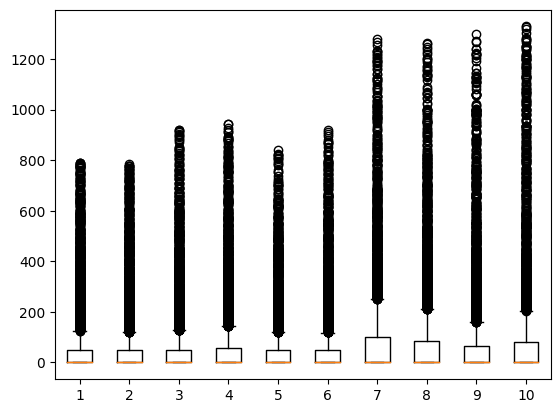

,8,9,10,1,2,3,4,5,6,7,ca_avg_utilz_lst_6_mnths,ca_avg_utilz_lst_3_mnths,ca_current_utilz
count,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000
mean,710.849162,684.489713,674.604633,628.998268,608.854894,651.374138,632.563887,604.288316,638.871655,732.146211,24.438202,24.737079,25.065597
std,1740.405483,1638.449323,1597.713398,1656.131809,1633.724986,1626.898607,1613.647260,1576.587346,1667.019838,1784.397874,29.804910,31.448811,32.565268
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-66.000000,-110.000000,-137.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
50%,2.000000,0.000000,4.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,9.000000
75%,505.570000,523.850000,531.600000,315.780000,314.610000,368.000000,379.080000,339.200000,370.150000,514.600000,37.000000,38.000000,40.000000
max,40200.000000,30795.090000,25726.960000,26300.670000,41222.000000,25731.130000,30978.090000,33906.390000,33770.500000,34135.470000,130.000000,341.000000,145.000000


In [73]:
import matplotlib.pyplot as plt
import numpy as np
numerical_cols = ['1','2','3','4','5','6','7','8','9','10'] 

Q1 = df_pivot[numerical_cols].quantile(0.25)
Q3 = df_pivot[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

df_cleaned = df_pivot[~((df_pivot[numerical_cols] < (Q1 - 1.5 * IQR)) | (df_pivot[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
plt.boxplot(df_cleaned[numerical_cols])
plt.show()

df_pivot.describe()

In [ ]:
# Last resort for prediction if needed Not NEEDED!!! Facebook model, was not back easy to use but did not give good predictions, too general for all people.
# Gave good intervals for answer though, but not good predictions.
import pandas as pd
from prophet import Prophet
df_melted = df_pivot.melt(id_vars=['current_account_nbr'], var_name='cycle', value_name='sales')

# Generate repeated date range for each account
accounts = df_pivot['current_account_nbr'].unique()  # Unique accounts
dates = pd.date_range(start='2024-01-01', periods=12, freq='M')  # Monthly frequency

df_melted['ds'] = pd.concat([pd.Series(dates) for _ in range(len(accounts))], ignore_index=True)
df_melted.rename(columns={'sales': 'y'}, inplace=True)
df_melted.dropna(subset=['ds'], inplace=True)
model = Prophet()
model.fit(df_melted[['ds', 'y']])
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

/var/folders/9b/zl_w0cqn4z7gl3f1kbbq3zmm0000gn/T/ipykernel_60060/1850122410.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2024-01-01', periods=12, freq='M')  # Monthly frequency
19:56:18 - cmdstanpy - INFO - Chain [1] start processing
19:56:25 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat   yhat_lower   yhat_upper
0  2024-01-31  548.578254 -1534.607515  2547.806685
1  2024-02-29  570.555400 -1438.811020  2609.501235
2  2024-03-31  511.100357 -1495.522331  2325.620897
3  2024-04-30  550.253050 -1564.831000  2523.433487
4  2024-05-31  589.301973 -1298.042414  2553.606416
5  2024-06-30  537.842202 -1440.028855  2488.838162
6  2024-07-31  539.547904 -1516.220509  2514.564248
7  2024-08-31  589.683998 -1317.999107  2607.293311
8  2024-09-30  545.807685 -1477.801076  2468.574146
9  2024-10-31  563.649146 -1396.943887  2418.896572
10 2024-11-30  545.037391 -1378.325166  2504.508531
11 2024-12-31  525.805244 -1532.518218  2277.904015
12 2025-01-31  506.573097 -1626.421626  2532.338467
13 2025-02-28  489.202125 -1495.738583  2482.344101
14 2025-03-31  469.969978 -1464.043889  2395.025450


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


2025-03-29 20:05:13.384064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
234/234 [==============================] - 19s 60ms/step - loss: 3730653.7500 - val_loss: 3210926.5000
Epoch 2/3
234/234 [==============================] - 10s 44ms/step - loss: 3601964.0000 - val_loss: 3115402.2500
Epoch 3/3
59/59 [==============================] - 1s 6ms/step


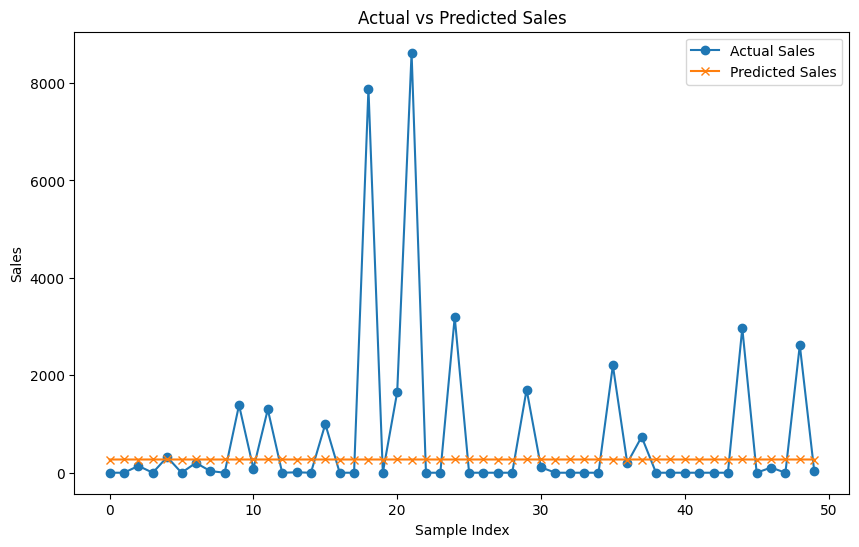

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = df_pivot.copy()
# scaled_data = scaler.fit_transform(data.iloc[:, 1:-3])
scaled_data = data.iloc[:, 1:-3].values 
import numpy as np


time_steps = 1

# Create sequences
X = []
y = []
for i in range(len(scaled_data)):
    if i + time_steps < len(scaled_data):  # Ensure we don't go out of bounds
        X.append(scaled_data[i:i + time_steps, 0])  # Use a window of `time_steps`
        y.append(scaled_data[i + time_steps, -1])   # Target is the next cycle's sales

X = np.array(X).reshape(-1, time_steps, 1)  # Reshape to (samples, timesteps, features)
y = np.array(y)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the model
model = Sequential()
model.add(LSTM(units=500, return_sequences=True, input_shape=(time_steps, 1)))  # First LSTM layer
model.add(LSTM(units=500))  # Second LSTM layer
model.add(Dense(units=1))  # Output layer


model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

test_loss = model.evaluate(X_test, y_test)

# Predict next cycle's sales
predictions = model.predict(X_test)


predictions_original_scale = predictions.flatten()
y_test_original_scale = y_test.flatten()
# predictions_placeholder = np.zeros((predictions.shape[0], scaled_data.shape[1]))
# predictions_placeholder[:, -1] = predictions.flatten()  # Fill only the sales column


# # Inverse transform predictions
# predictions_original_scale = scaler.inverse_transform(predictions_placeholder)[:, -1]

# # Inverse transform y_test for actual values
# y_test_placeholder = np.zeros((y_test.shape[0], scaled_data.shape[1]))
# y_test_placeholder[:, -1] = y_test.flatten()
# y_test_original_scale = scaler.inverse_transform(y_test_placeholder)[:, -1]

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_scale[:50], label='Actual Sales', marker='o')
plt.plot(predictions_original_scale[:50], label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.show()




Epoch 1/30
234/234 [==============================] - 9s 13ms/step - loss: 0.0320 - mae: 0.1393 - val_loss: 0.0239 - val_mae: 0.1282
Epoch 2/30
234/234 [==============================] - 2s 10ms/step - loss: 0.0261 - mae: 0.1263 - val_loss: 0.0236 - val_mae: 0.1171
Epoch 3/30
234/234 [==============================] - 2s 10ms/step - loss: 0.0255 - mae: 0.1255 - val_loss: 0.0232 - val_mae: 0.1184
Epoch 4/30
234/234 [==============================] - 2s 8ms/step - loss: 0.0249 - mae: 0.1245 - val_loss: 0.0230 - val_mae: 0.1220
Epoch 5/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0245 - mae: 0.1235 - val_loss: 0.0254 - val_mae: 0.1412
Epoch 6/30
234/234 [==============================] - 3s 13ms/step - loss: 0.0247 - mae: 0.1242 - val_loss: 0.0231 - val_mae: 0.1237
Epoch 7/30
234/234 [==============================] - 3s 11ms/step - loss: 0.0243 - mae: 0.1234 - val_loss: 0.0232 - val_mae: 0.1182
Epoch 8/30
234/234 [==============================] - 2s 10ms/step - l

IndexError: index 1 is out of bounds for axis 1 with size 1

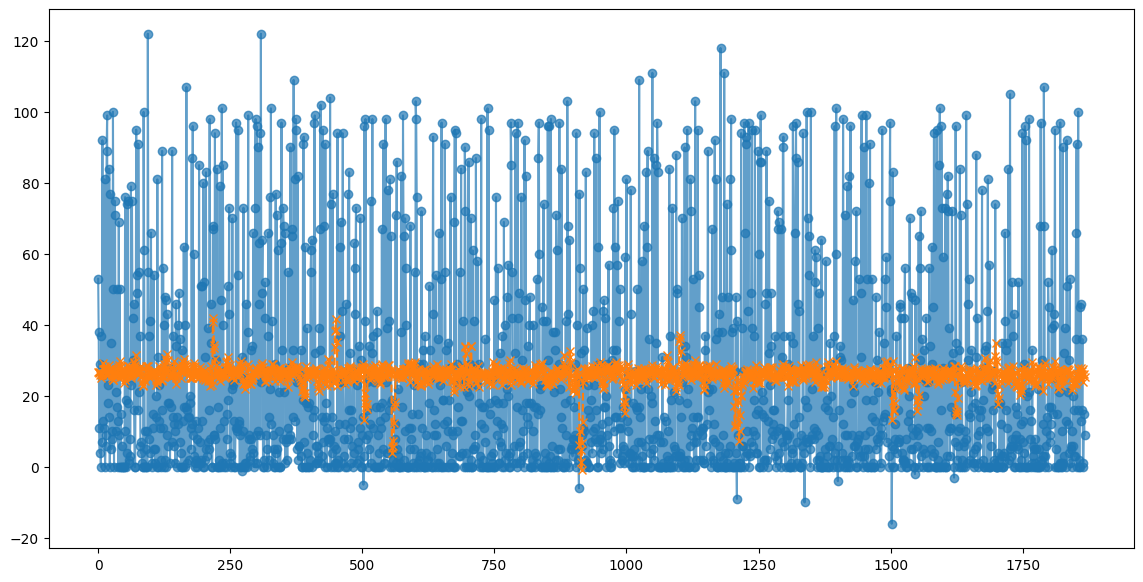

In [ ]:
# Install required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


TIME_STEPS = 7      
PREDICTION_STEPS = 1  
TARGET_INDEX = -3    
TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS = 30
BATCH_SIZE = 32


data = df_pivot.copy()


features = data.iloc[:, 1:TARGET_INDEX].values
temporal_features = data.iloc[:, TARGET_INDEX:-1].values  # Non-scaled temporal features
target = data.iloc[:, TARGET_INDEX].values.reshape(-1, 1)  # Sales column


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)


scaled_data = np.hstack([
    scaled_features,
    temporal_features,
    scaled_target
])


X, y = [], []
for i in range(len(scaled_data) - TIME_STEPS - PREDICTION_STEPS + 1):
    X.append(scaled_data[i:i+TIME_STEPS, :-1])  # All features except target
    y.append(scaled_data[i+TIME_STEPS:i+TIME_STEPS+PREDICTION_STEPS, -1])  # Target values

X = np.array(X)
y = np.array(y)

# Split data
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(PREDICTION_STEPS)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict and inverse scaling 
def inverse_scale_predictions(predictions):
    """Inverse transform predictions using target scaler"""
    return target_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, PREDICTION_STEPS)

predictions = model.predict(X_test)
predictions_original = inverse_scale_predictions(predictions)
y_test_original = inverse_scale_predictions(y_test)

# Visualization 
plt.figure(figsize=(14, 7))

# Cycle 1 predictions
plt.plot(y_test_original[:, 0], label='Actual Cycle 1', alpha=0.7, marker='o')
plt.plot(predictions_original[:, 0], label='Predicted Cycle 1', linestyle='--', marker='x')

# Cycle 2 predictions ignore becuase graph looks too messy although idk if we can fix that
# plt.plot(y_test_original[:, 1], label='Actual Cycle 2', alpha=0.7, marker='s')
# plt.plot(predictions_original[:, 1], label='Predicted Cycle 2', linestyle='--', marker='^')

plt.title(f'{PREDICTION_STEPS}-Cycle Sales Prediction Comparison')
plt.ylabel('Sales')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Evaluation:\nTest Loss: {test_loss:.4f}\nTest MAE: {test_mae:.4f}")

# Prediction examples
print("\nSample Predictions vs Actuals:")
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"Predicted: {predictions_original[i]}")
    print(f"Actual:    {y_test_original[i]}\n")
# oh no... where did it all go wrong??

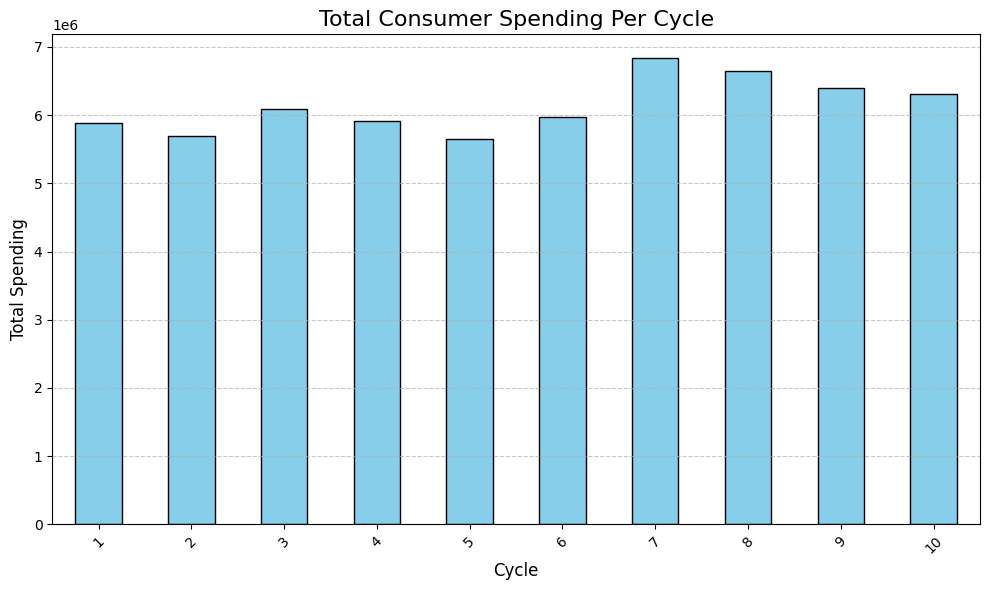

In [37]:
cycle_columns = [f'{col}' for col in range(1, 11)]
spending_per_cycle = df_pivot[cycle_columns].sum()


plt.figure(figsize=(10, 6))
spending_per_cycle.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Consumer Spending Per Cycle', fontsize=16)
plt.xlabel('Cycle', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

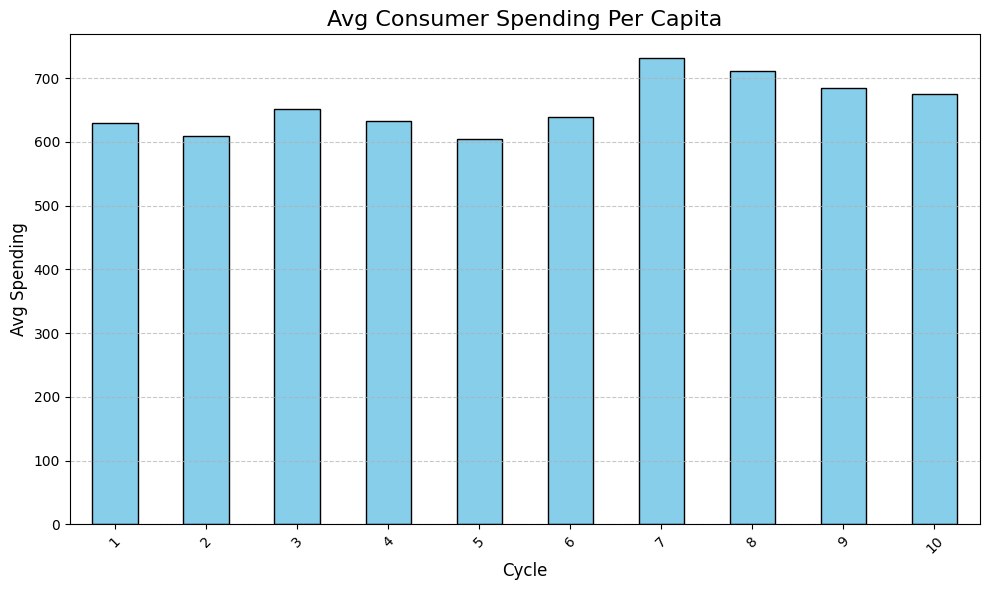

In [40]:
df = df_pivot.copy()
cycle_columns = [f'{col}' for col in range(1, 11)]
spending_per_cycle = df[cycle_columns].mean()

plt.figure(figsize=(10, 6))
spending_per_cycle.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Avg Consumer Spending Per Capita', fontsize=16)
plt.xlabel('Cycle', fontsize=12)
plt.ylabel('Avg Spending', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from pmdarima import auto_arima 
import warnings 
warnings.filterwarnings("ignore") 
  



df_melted = df_pivot.melt(id_vars=['current_account_nbr'], var_name='cycle', value_name='sales')

# Generate repeated date range for each account
accounts = df_pivot['current_account_nbr'].unique() 
dates = pd.date_range(start='2024-01-01', periods=12, freq='M') 

# Repeat dates for each account
df_melted['ds'] = pd.concat([pd.Series(dates) for _ in range(len(accounts))], ignore_index=True)
df_melted.rename(columns={'sales': 'y'}, inplace=True)
df_melted.dropna(subset=['ds'], inplace=True)

# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df_melted["y"], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,  
                          stepwise = True)           
  
# 
stepwise_fit.summary() 
# took too long to run, so I stopped it but it might be promising unsure ;( ).


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=240.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2036203.462, Time=8.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2004730.327, Time=140.06 sec


: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


df = df_pivot.copy()

numerical_cols = ['1', '2', '3', '4', '5', '6', '7', 'ca_avg_utilz_lst_6_mnths', 'ca_avg_utilz_lst_3_mnths', 'ca_current_utilz']  

df.head()

df_test = df.sample(frac=0.2, random_state=42)

df_train = df.drop(df_test.index)

X_train = df_train[numerical_cols]
y_train = df_train[['8', '9', '10']]

X_test = df_test[numerical_cols]
y_test = df_test[['8', '9', '10']]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


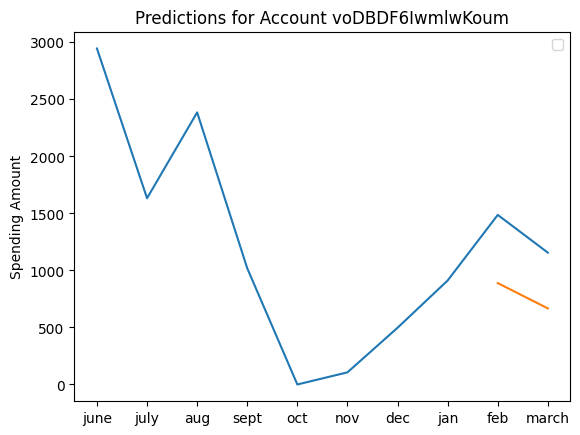

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


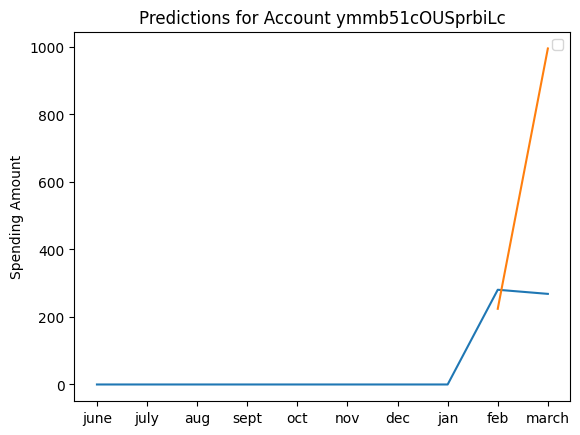

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


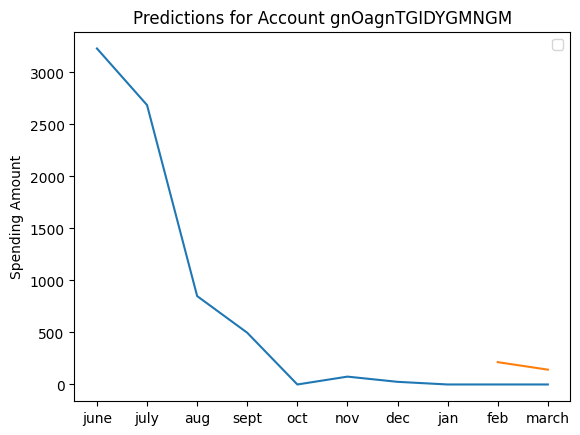

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


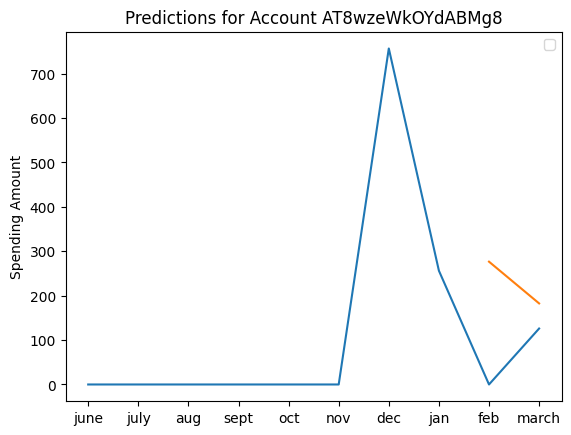

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


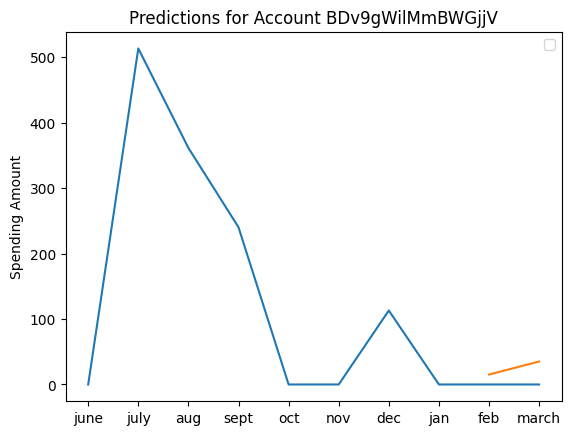

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


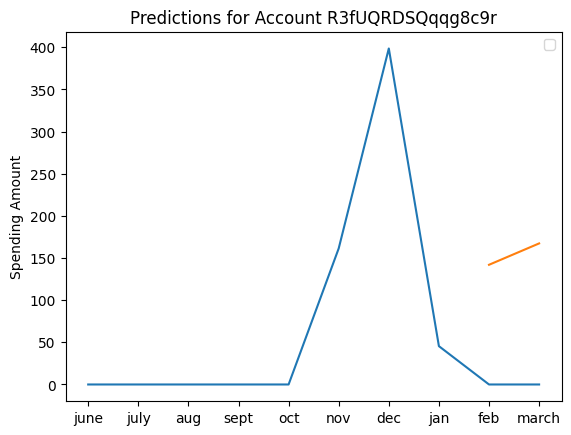

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


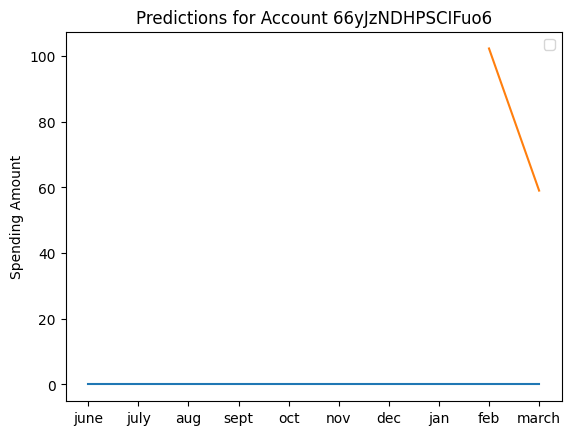

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


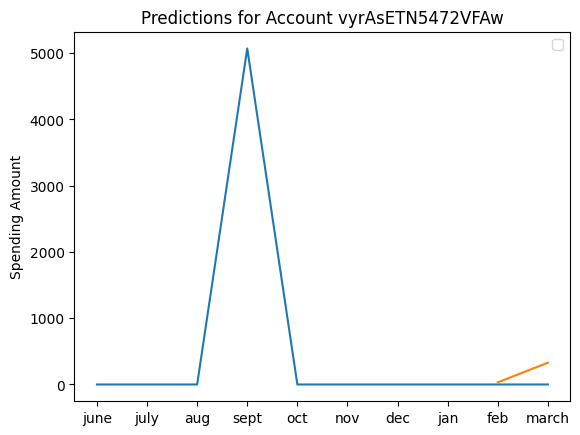

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


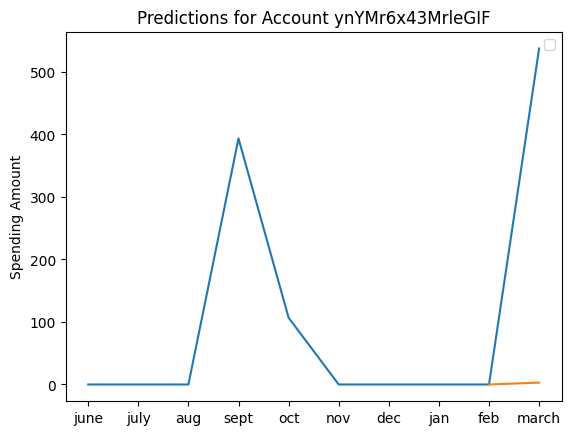

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


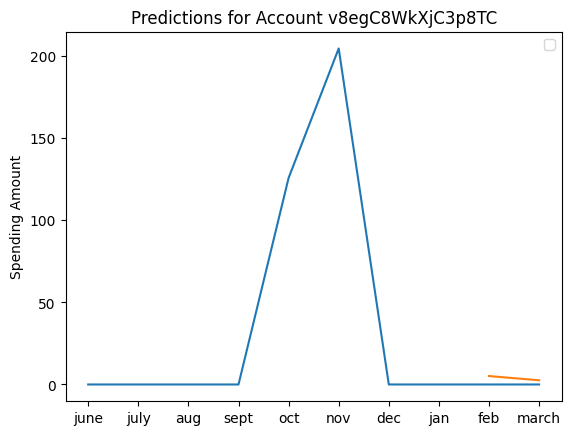

In [49]:
df_test['hat9'] = y_pred[:, 0]
df_test['hat10'] = y_pred[:, 1]
df_test['error9'] = df_test['9'] - df_test['hat9']
df_test['error10'] = df_test['10'] - df_test['hat10']

np.mean(np.array(df_test['error9'])**2)
labels = ["june", 'july', 'aug', 'sept', 'oct', 'nov', 'dec', 'jan', 'feb', 'march']



sample_indices = df_test.sample(10).index
for idx in sample_indices:
    plt.title(f"Predictions for Account {df.loc[idx, 'current_account_nbr']}")
    plt.ylabel('Spending Amount')
    plt.legend()
    plt.plot(labels,df_test[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].loc[idx].T, label = "actual")
    plt.plot(labels[8:],df_test[['hat9', 'hat10']].loc[idx].T, label = "predicted")
    plt.show()
    

In [111]:
df_test.describe()

,8,9,10,1,2,3,4,5,6,7,ca_avg_utilz_lst_6_mnths,ca_avg_utilz_lst_3_mnths,ca_current_utilz,hat9,hat10,error9,error10
count,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,727.826961,655.074708,650.129085,633.408133,599.464778,632.692488,605.948828,558.049053,651.998684,678.071915,24.483681,24.582665,24.887105,693.354839,681.481909,-38.280131,-31.352824
std,1784.608955,1541.395390,1543.827973,1650.614822,1586.995881,1654.381318,1617.713183,1450.430219,1780.749905,1585.579814,29.896151,31.084850,32.345756,1279.276390,1200.839222,1019.585712,981.484173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-19.000000,-20.000000,0.000000,0.000000,-10274.675700,-6276.023278
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,24.977400,24.236100,-186.647480,-202.200897
50%,7.120000,0.000000,7.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.640000,11.000000,10.000000,9.000000,138.570500,158.172200,-38.720846,-29.997200
75%,567.120000,526.430000,531.600000,336.360000,354.940000,337.220000,388.540000,348.000000,375.780000,537.910000,36.000000,39.000000,39.000000,705.696500,746.765800,0.000000,0.000000
max,25987.980000,17687.060000,19996.330000,26300.670000,20855.920000,24527.430000,25478.680000,18951.560000,33612.090000,22632.160000,130.000000,143.000000,145.000000,13774.675700,8128.849800,10928.669900,12443.510000


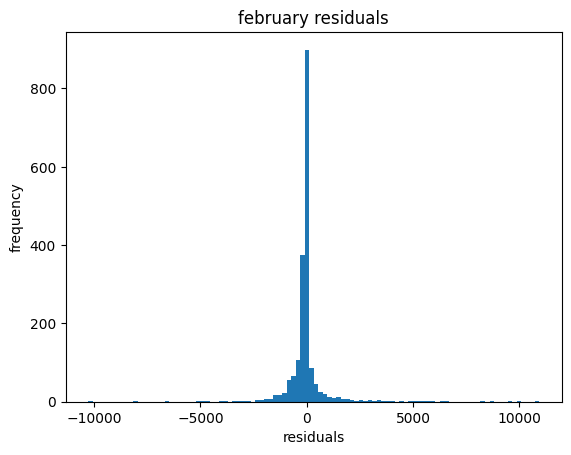

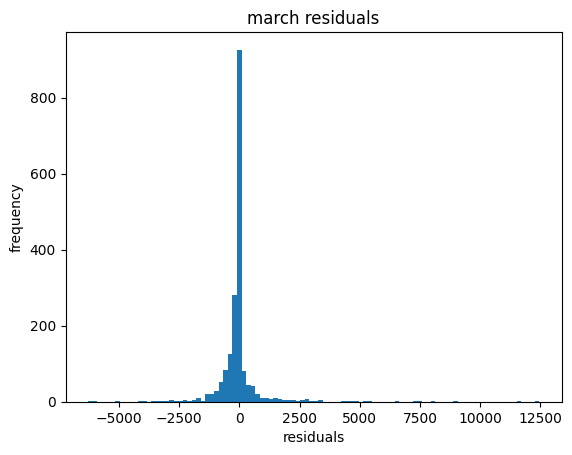

In [106]:
plt.hist(df_test['error9'], bins = 100)
plt.title('february residuals')
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.show()


plt.hist(df_test['error10'], bins = 100)
plt.title('march residuals')
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.show()

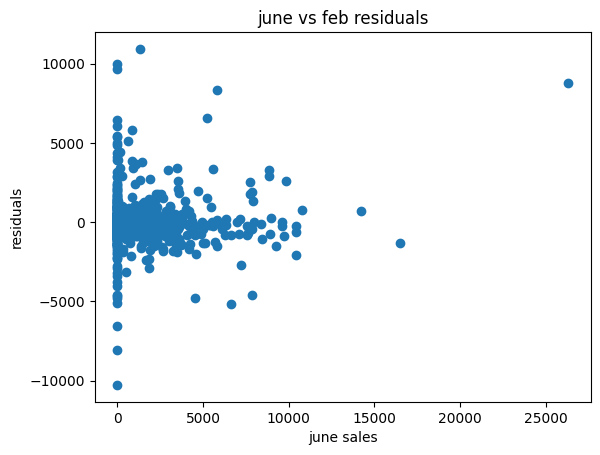

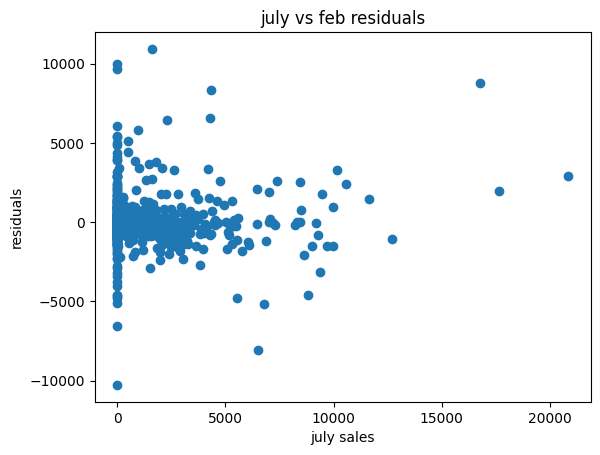

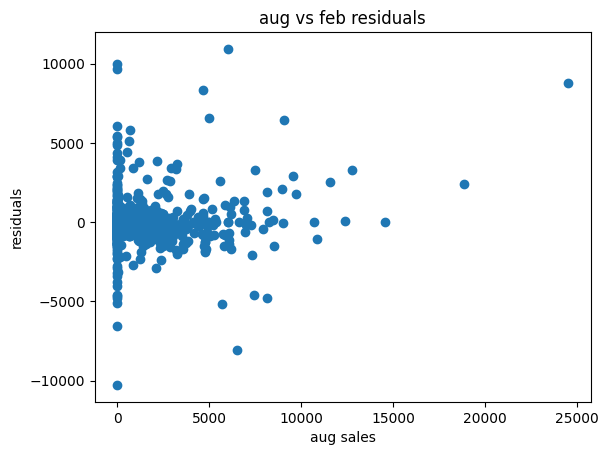

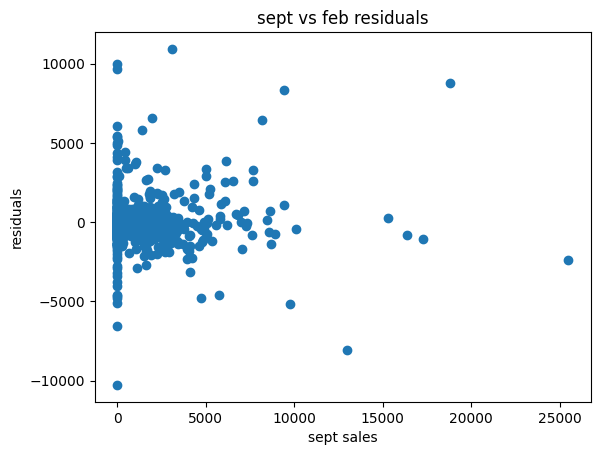

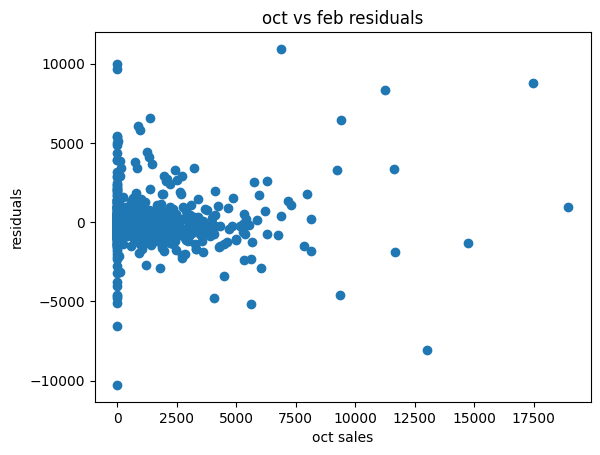

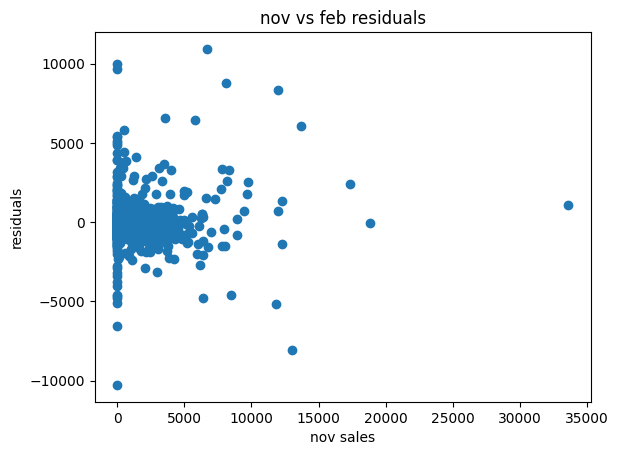

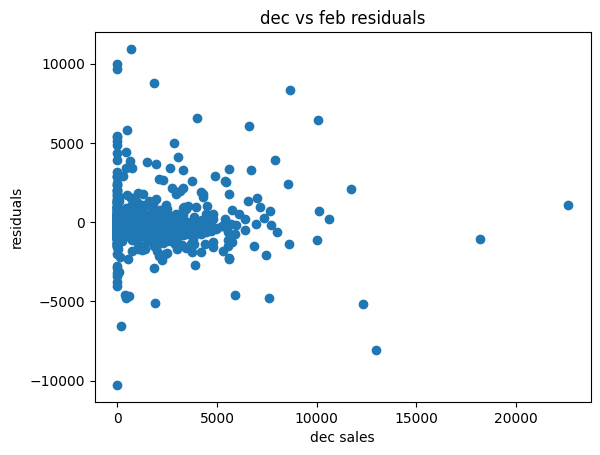

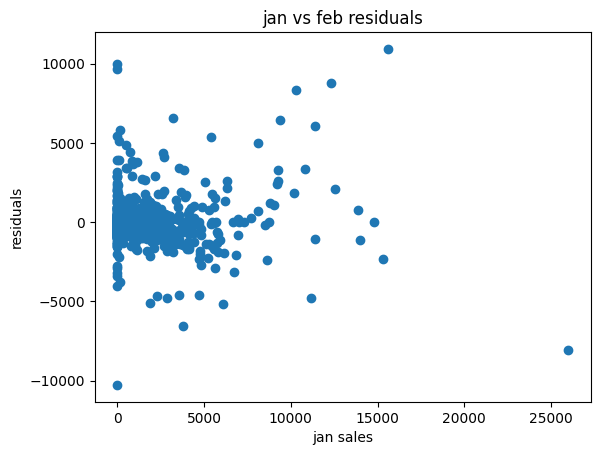

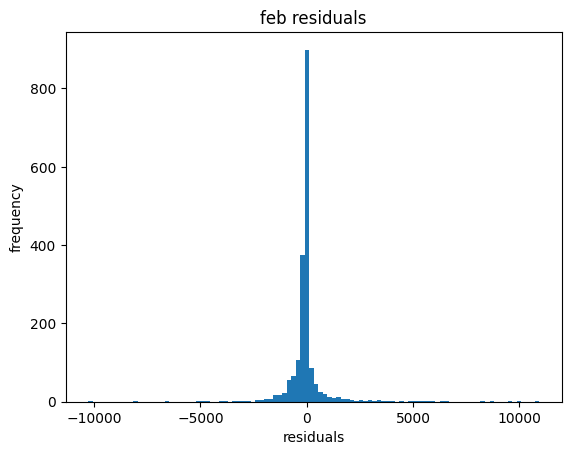

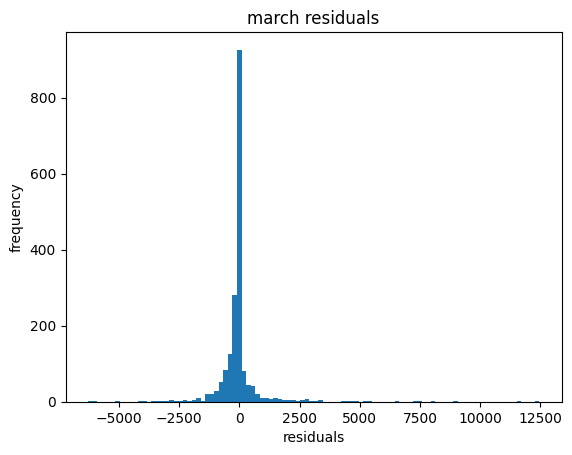

In [110]:
plt.scatter(df_test['1'], df_test['error9'])
plt.title('june vs feb residuals')
plt.xlabel('june sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['2'], df_test['error9'])
plt.title('july vs feb residuals')
plt.xlabel('july sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['3'], df_test['error9'])
plt.title('aug vs feb residuals')
plt.xlabel('aug sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['4'], df_test['error9'])
plt.title('sept vs feb residuals')
plt.xlabel('sept sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['5'], df_test['error9'])
plt.title('oct vs feb residuals')
plt.xlabel('oct sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['6'], df_test['error9'])
plt.title('nov vs feb residuals')
plt.xlabel('nov sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['7'], df_test['error9'])
plt.title('dec vs feb residuals')
plt.xlabel('dec sales')
plt.ylabel('residuals')
plt.show()

plt.scatter(df_test['8'], df_test['error9'])
plt.title('jan vs feb residuals')
plt.xlabel('jan sales')
plt.ylabel('residuals')
plt.show()


plt.hist(df_test['error9'], bins = 100)
plt.title('feb residuals')
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.show()

plt.hist(df_test['error10'], bins = 100)
plt.title('march residuals')
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.86      0.78       573
           1       0.93      0.84      0.88      1296

    accuracy                           0.85      1869
   macro avg       0.82      0.85      0.83      1869
weighted avg       0.86      0.85      0.85      1869


Training regression model for 8

Training regression model for 9

Training regression model for 10
8 RMSE: 1450.00
9 RMSE: 1635.86
10 RMSE: 1439.40

Overall RMSE: 1510.82
90% CI accuracy: 94.471%


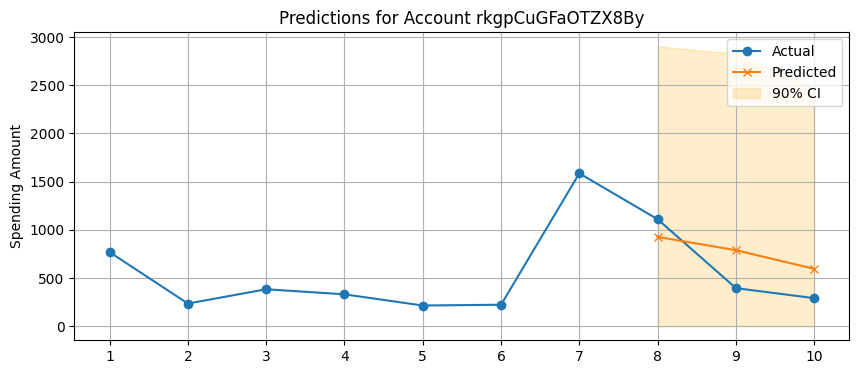

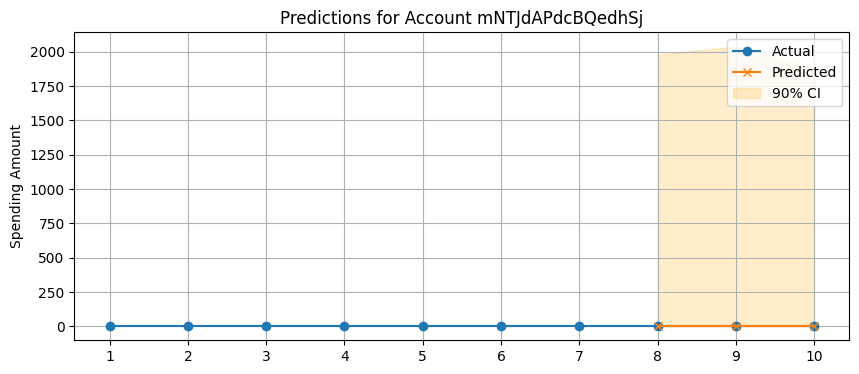

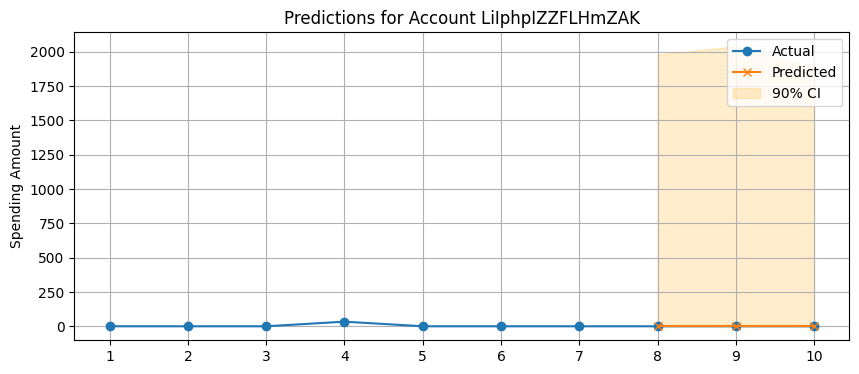

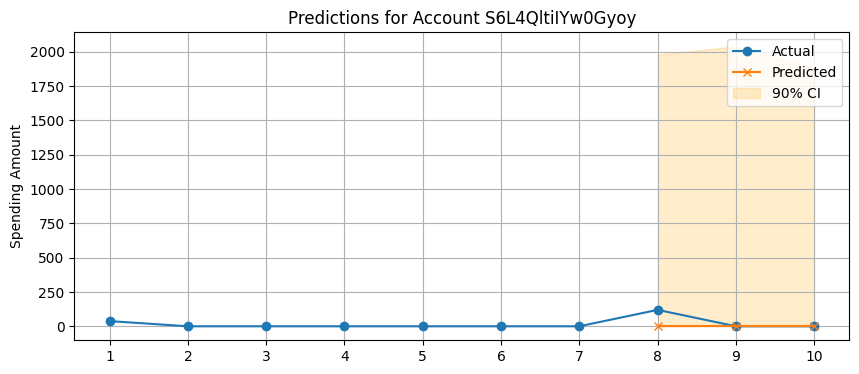

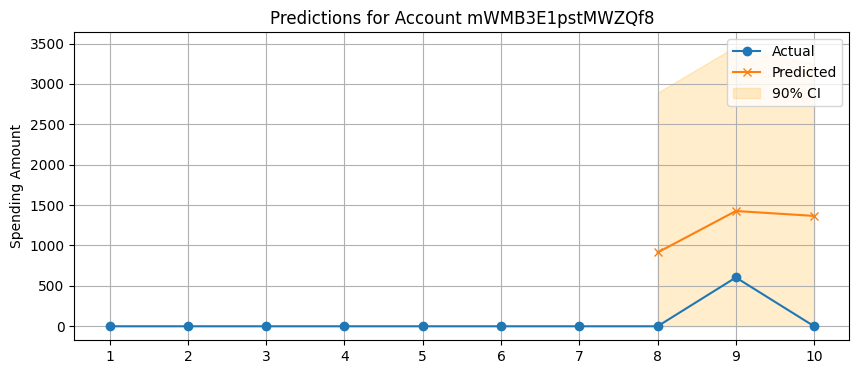

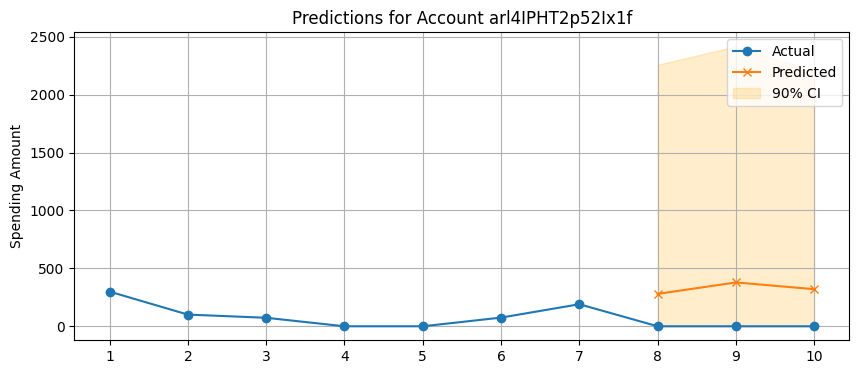

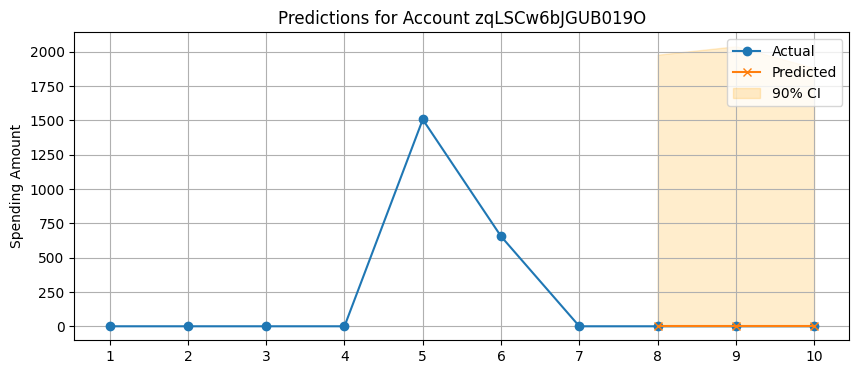

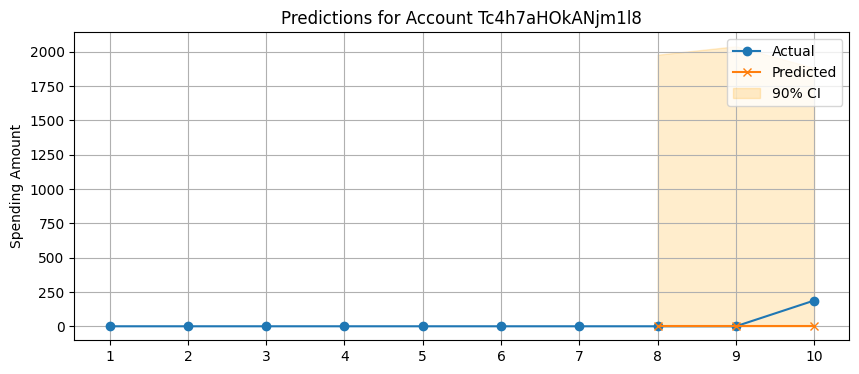

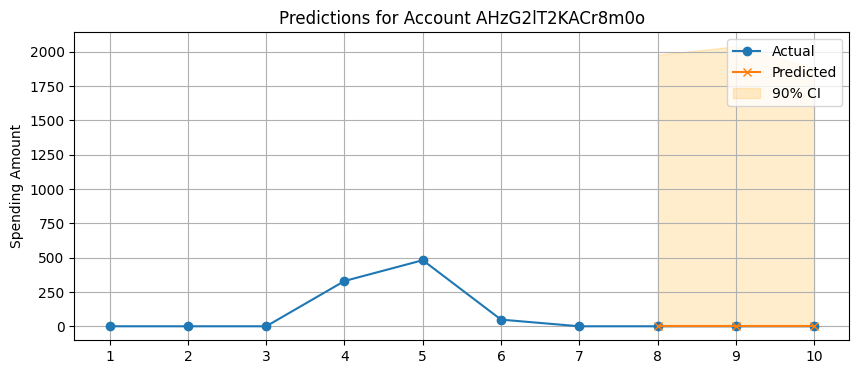

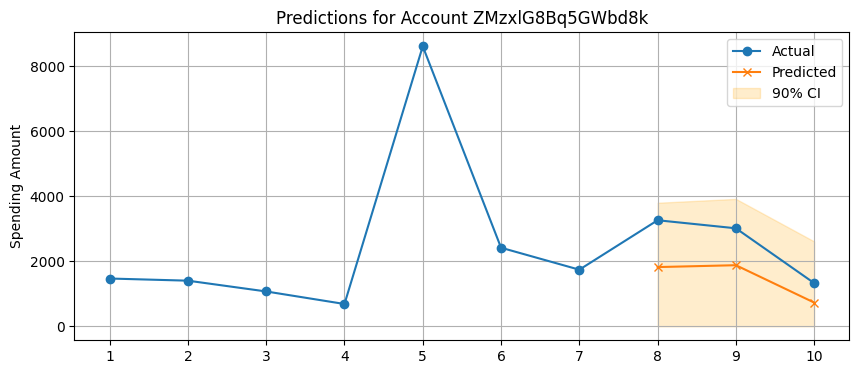

In [95]:
    import pandas as pd
    import numpy as np
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, mean_squared_error
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.base import clone

    df = df_pivot
    # Feature columns
    feature_cols = ['1', '2', '3', '4', '5', '6', '7', 'ca_avg_utilz_lst_6_mnths', 'ca_avg_utilz_lst_3_mnths', 'ca_current_utilz']

    # Target columns
    target_cols = [f'{i}' for i in range(8, 11)]

    # Split data (random for now, looks to work well but we can do more formal ones if needed) (Other methods that could be attempted are k-fold or leave one out however it seems like random is good enough for now)
    train = df.sample(frac=0.8, random_state=42)
    test = df.drop(train.index)

    train['has_spending'] = (train[target_cols].sum(axis=1) > 0).astype(int)
    test['has_spending'] = (test[target_cols].sum(axis=1) > 0).astype(int)

    # First Step Classification between people that never spend anything and people that spend money

    # Preprocessing pipeline for classification
    clf_preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), feature_cols),
        ])

    clf_pipeline = Pipeline([
        ('preprocessor', clf_preprocessor),
        ('classifier', RandomForestClassifier(
            # Change this if over or under fitting, 
            n_estimators=500,
            max_depth=50,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42
        ))
    ])

    # Train classifier
    clf_pipeline.fit(train[feature_cols], train['has_spending'])

    # Evaluate classifier
    test_preds_clf = clf_pipeline.predict(test[feature_cols])
    print("Classification Report:\n", classification_report(test['has_spending'], test_preds_clf))

    #Regression Time!, instead of if they spend now we calc how much do people spend.
    from sklearn.dummy import DummyRegressor
    train_reg = train[train['has_spending'] == 1]
    test_reg = test[test['has_spending'] == 1]
    reg_models = {}

    reg_preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), feature_cols),
        ])

    from lightgbm import LGBMRegressor
    # Both regressors work, We chose LGBM as it seemed to have more consistant results
    reg_pipeline = Pipeline([
        ('preprocessor', reg_preprocessor),
        ('regressor', LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=7,
            num_leaves=8,
            random_state=42
        ))
    ])


    # reg_pipeline = Pipeline([
    #     ('preprocessor', reg_preprocessor),
    #     ('regressor', GradientBoostingRegressor(
    #         n_estimators=100,
    #         learning_rate=0.05,
    #         max_depth=7,
    #         random_state=42
    #     ))
    # ])

    for cycle in target_cols:
        print(f"\nTraining regression model for {cycle}")
        
        # Filter rows with actual spending for this specific cycle
        mask = train_reg[cycle] > 0
        X_train_cycle = train_reg.loc[mask, feature_cols]
        y_train_cycle = train_reg.loc[mask, cycle]
        
        if len(X_train_cycle) > 0:
            # Clone and fit pipeline if data exists
            cycle_pipeline = clone(reg_pipeline)
            cycle_pipeline.fit(X_train_cycle, y_train_cycle)
            reg_models[cycle] = cycle_pipeline
        else:
            # Create dummy model if no training data points
            print(f"No training data for {cycle}, using dummy model")
            reg_models[cycle] = DummyRegressor(strategy='constant', constant=0)
            reg_models[cycle].fit(X_train_cycle, y_train_cycle)

    # Predicting Time

    def predict_two_stage(df, feature_cols):

        has_spending_proba = clf_pipeline.predict_proba(df[feature_cols])[:, 1]
        
        predictions = pd.DataFrame(index=df.index, columns=target_cols)
        lower_bounds = pd.DataFrame(index=df.index, columns=target_cols)
        upper_bounds = pd.DataFrame(index=df.index, columns=target_cols)

        for cycle in target_cols:
            cycle_weight = 1.0  # If you want to weight the predictions, you can adjust this value but we didnt see any so it was set to 1.0
            
            # Threshold for spending occurrence (can be tuned)
            spend_mask = has_spending_proba * cycle_weight > 0.7
            
            # Predict amounts for predicted spenders
            if spend_mask.any():
                cycle_preds = reg_models[cycle].predict(df.loc[spend_mask, feature_cols])
                predictions.loc[spend_mask, cycle] = np.maximum(0,cycle_preds)
            
            # Set non-spenders to zero
            predictions.loc[~spend_mask, cycle] = 0

            residuals = reg_models[cycle].predict(df[feature_cols]) - df[cycle]
            residual_std = np.std(residuals)

            lower_bound = predictions.loc[:, cycle] - 1.645 * residual_std
            upper_bound = predictions.loc[:, cycle] + 1.645 * residual_std

            lower_bounds.loc[:, cycle] = np.maximum(0, lower_bound)
            upper_bounds.loc[:, cycle] = upper_bound
        
        return predictions, lower_bounds, upper_bounds

    test_preds, test_lower, test_upper = predict_two_stage(test, feature_cols)

    # Evaluate predictions by RMSE

    def evaluate_predictions(actual, predicted):
        """Evaluate model performance on test set"""
        results = {}
        
        for cycle in target_cols:
            mask = actual[cycle] > 0
            if mask.any():
                rmse = np.sqrt(mean_squared_error(actual.loc[mask, cycle], predicted.loc[mask, cycle]))
                results[cycle] = rmse
                print(f"{cycle} RMSE: {rmse:.2f}")
            else:
                results[cycle] = None
        
        # Overall RMSE across all cycles
        flat_actual = actual.values.flatten()
        flat_preds = predicted.values.flatten()
        mask = flat_actual > 0
        overall_rmse = np.sqrt(mean_squared_error(flat_actual[mask], flat_preds[mask]))
        print(f"\nOverall RMSE: {overall_rmse:.2f}")
        
        return results

    evaluation_results = evaluate_predictions(test[target_cols], test_preds)

    def calculate_ci_accuracy(actual, lower, upper):
        actual_vals = actual.values.flatten()
        lower_vals = lower.values.flatten()
        upper_vals = upper.values.flatten()

        ci_accuracy = ((actual_vals >= lower_vals) & (actual_vals <= upper_vals)).mean()
        return ci_accuracy

    ci_accuracy = calculate_ci_accuracy(test[target_cols], test_lower, test_upper)

    print(f"90% CI accuracy: {ci_accuracy:.3%}")

    # Graphing

    import matplotlib.pyplot as plt

    def plot_predictions(actual, predicted, lower, upper, n_samples=10):
        
        sample_indices = actual.sample(n_samples).index
        
        for idx in sample_indices:
            plt.figure(figsize=(10, 4))

            x_axis = list(target_cols) 
            lower_vals = lower.loc[idx, target_cols].astype(float).fillna(0) 
            upper_vals = upper.loc[idx, target_cols].astype(float).fillna(0) 
            
            plt.plot(['1','2','3','4','5','6','7']+ target_cols, actual.loc[idx], label='Actual', marker='o')
            plt.plot(target_cols, predicted.loc[idx], label='Predicted', marker='x')
            plt.fill_between(x_axis, lower_vals, upper_vals, color='orange', alpha=0.2, label='90% CI')
            
            plt.title(f"Predictions for Account {df.loc[idx, 'current_account_nbr']}")
            plt.ylabel('Spending Amount')
            plt.legend()
            plt.grid(True)
            plt.show()

    plot_predictions(test[['1','2','3','4','5','6','7']+target_cols], test_preds, test_lower, test_upper)


Training regression model for 11
  Trained on 3748 examples

Training regression model for 12
  Trained on 3672 examples

Training regression model for 13
  Trained on 3768 examples

Training regression model for 14
  Trained on 3768 examples


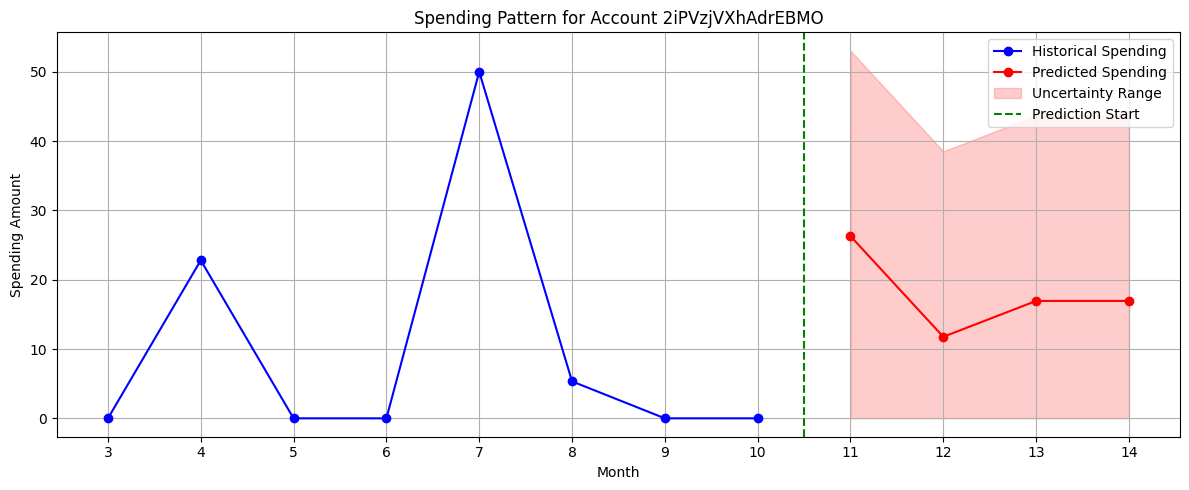

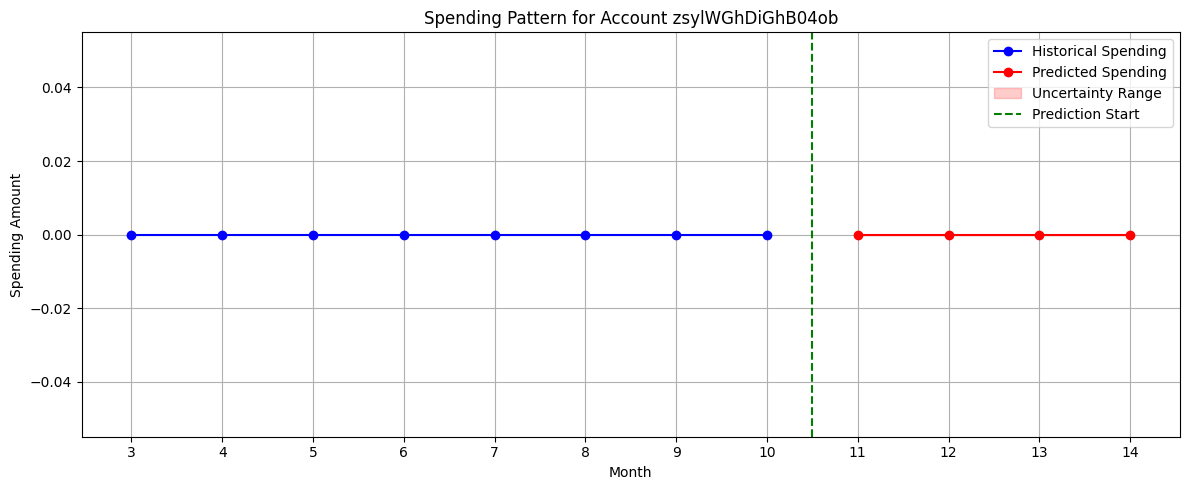

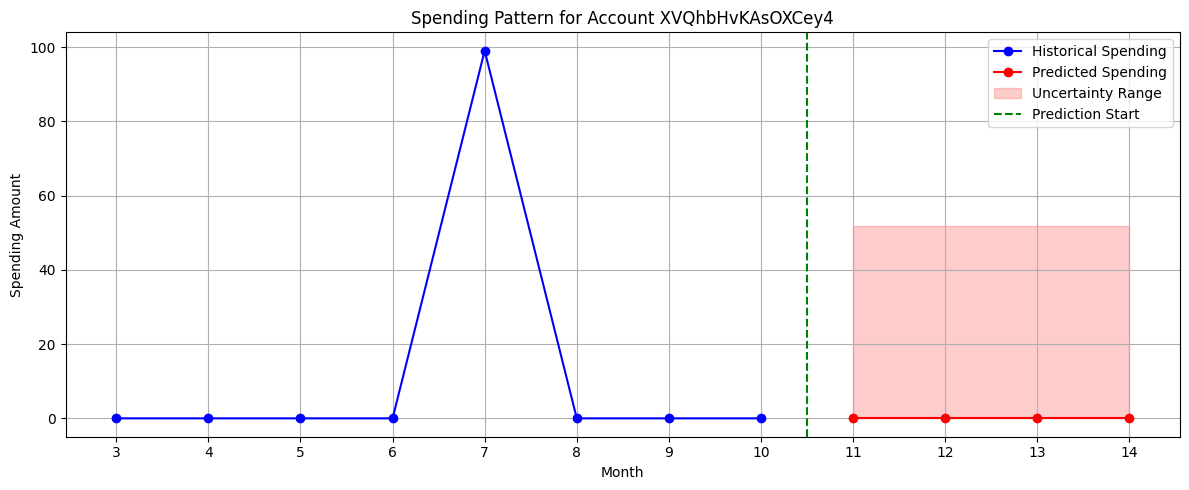

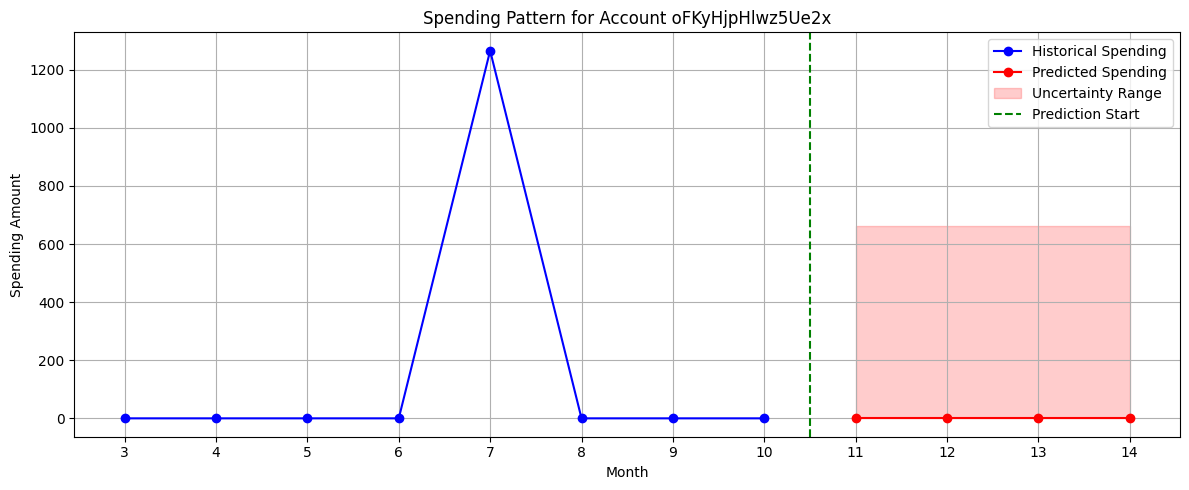

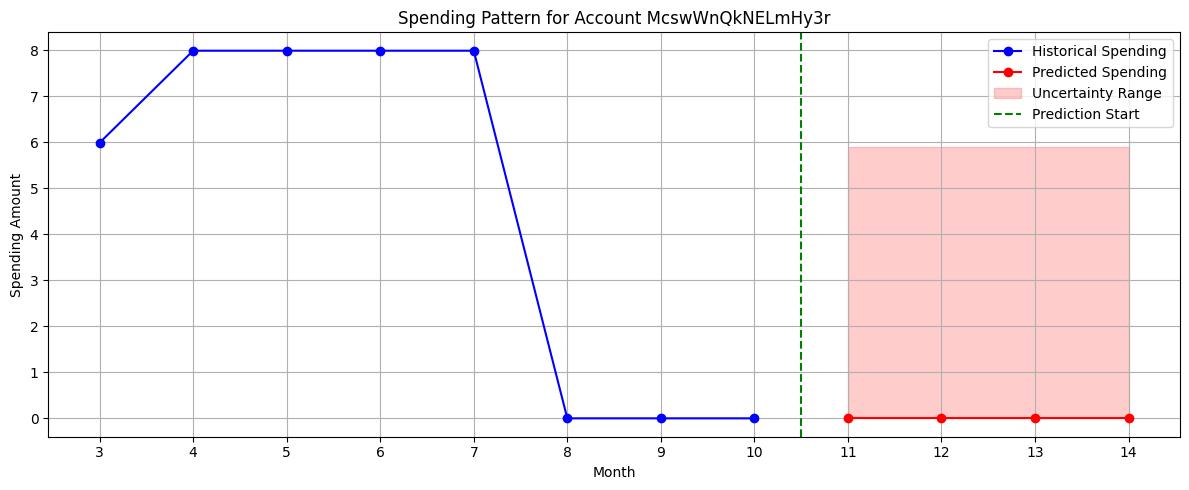

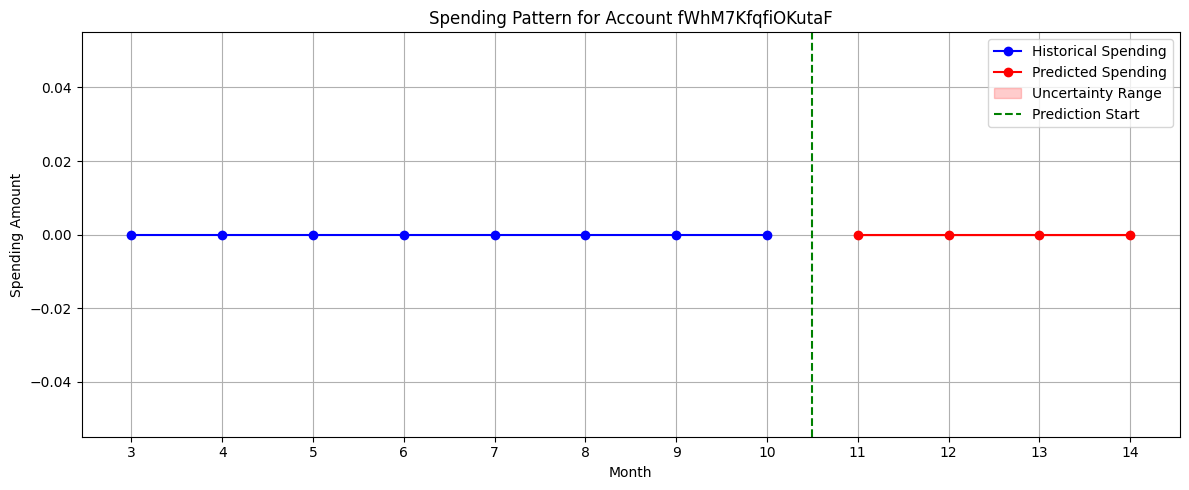

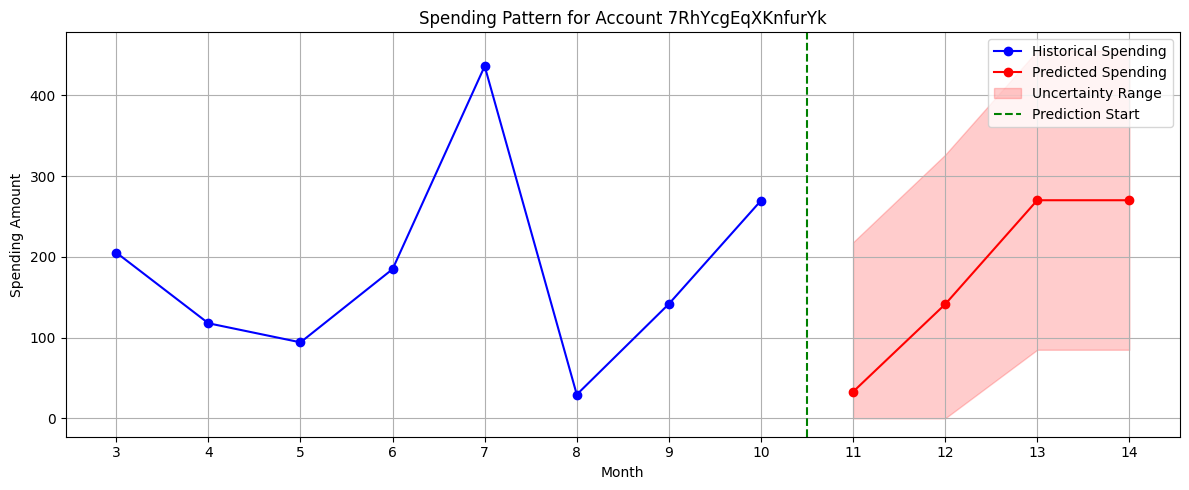

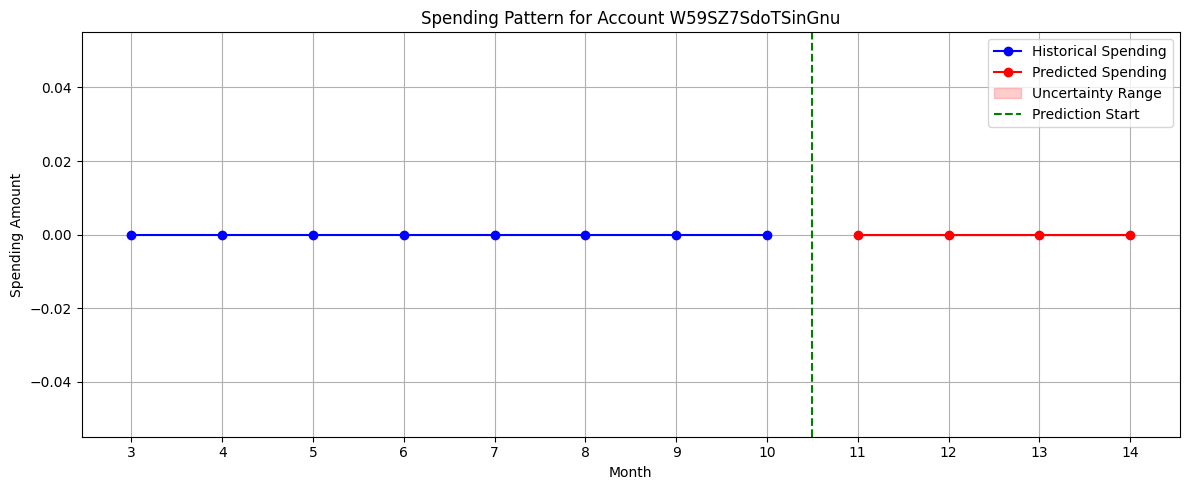

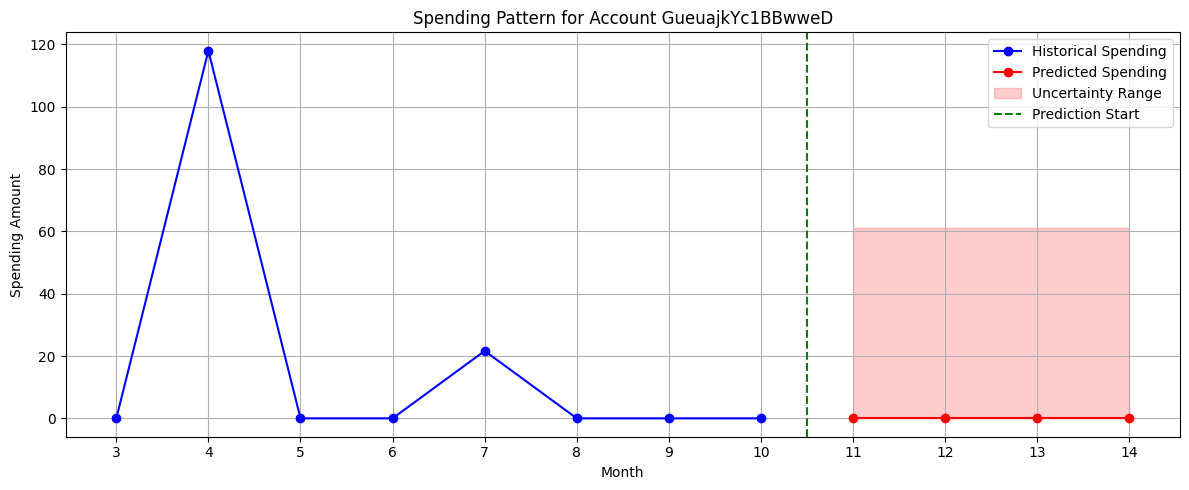

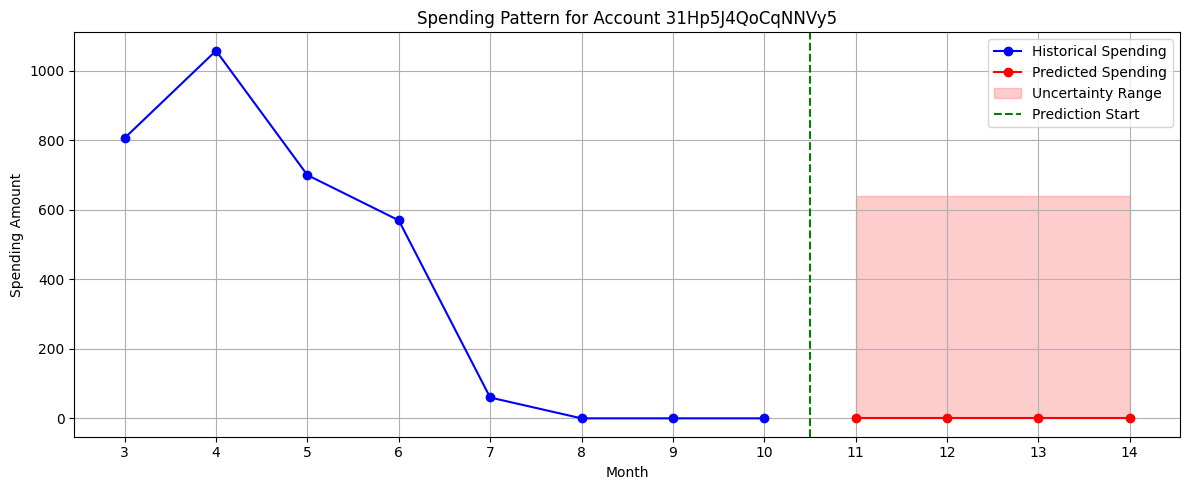

,account_nbr,predicted_11,lower_bound_11,upper_bound_11,predicted_12,lower_bound_12,upper_bound_12,predicted_13,lower_bound_13,upper_bound_13,predicted_14,lower_bound_14,upper_bound_14
0,00oyr3QppAzjLws4,13.134021,0,125.052562,31.577988,0,143.496528,10.945138,0,122.863678,10.945138,0,122.863678
1,02WRVV8yusgcZWLW,32.651006,0,2989.117262,509.162852,0,3465.629108,5681.649827,2725.183572,8638.116083,5681.649827,2725.183572,8638.116083
2,033o9yHYen3xoz6k,3281.627696,2396.863512,4166.39188,1816.232887,931.468703,2700.997071,2176.245197,1291.481013,3061.009381,2176.245197,1291.481013,3061.009381
3,034bM166vNmgLiIA,28.590409,0,570.892428,125.918843,0,668.220862,26.424845,0,568.726864,26.424845,0,568.726864
4,03cqv0gFjEIiQG0x,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0


In [101]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

df = df_pivot

#retraining on the past 8 months to predict the future 4
feature_cols = ['3', '4', '5', '6', '7', '8', '9', '10', 'ca_avg_utilz_lst_6_mnths', 'ca_avg_utilz_lst_3_mnths', 'ca_current_utilz']
target_cols = [f'{i}' for i in range(11, 15)]  # months 11-14 are april, may, june, and july of 2025

available_months = [col for col in df.columns if col in [str(i) for i in range(3, 15)]]
training_months = [m for m in available_months if int(m) < 11] 

train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)


# use spending pattern from months 8-10 as a proxy
proxy_cols = [str(i) for i in range(8, 11) if str(i) in df.columns]

train['has_spending'] = (train[proxy_cols].sum(axis=1) > 0).astype(int)
test['has_spending'] = (test[proxy_cols].sum(axis=1) > 0).astype(int)

# classification preprocessing pipeline
clf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), feature_cols),
    ])

# classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', clf_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ))
])

# train
clf_pipeline.fit(train[feature_cols], train['has_spending'])

# regression preparation - only use accounts with spending history
train_reg = train[train['has_spending'] == 1]
reg_models = {}

# regression preprocessing pipeline
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), feature_cols),
    ])

# regression pipeline
reg_pipeline = Pipeline([
    ('preprocessor', reg_preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=8,
        random_state=42,
        verbose=-1
    ))
])

# train model for each target month
for i, cycle in enumerate(target_cols):
    print(f"\nTraining regression model for {cycle}")
       
    # using last three known months as pattern
    proxy_cols = [str(i) for i in range(8, 11) if str(i) in df.columns]

    proxy_col = proxy_cols[min(i, len(proxy_cols)-1)] 
    mask = train_reg[proxy_col] > 0
    X_train_cycle = train_reg.loc[mask, feature_cols]
    y_train_cycle = train_reg.loc[mask, proxy_col]

    
    # fit pipeline 
    cycle_pipeline = clone(reg_pipeline)
    cycle_pipeline.fit(X_train_cycle, y_train_cycle)
    reg_models[cycle] = cycle_pipeline
    print(f"  Trained on {len(X_train_cycle)} examples")

# Prediction Time!
def predict_two_stage(df, feature_cols):
    has_spending_proba = clf_pipeline.predict_proba(df[feature_cols])[:, 1]
    
    predictions = pd.DataFrame(index=df.index, columns=target_cols)
    lower_bounds = pd.DataFrame(index=df.index, columns=target_cols)
    upper_bounds = pd.DataFrame(index=df.index, columns=target_cols)

    for cycle in target_cols:
        cycle_weight = 1.0 # can change
        
        # can also change this threshold
        spend_mask = has_spending_proba * cycle_weight > 0.7
        
        # if they spend money, then predict
        if spend_mask.any():
            cycle_preds = reg_models[cycle].predict(df.loc[spend_mask, feature_cols])
            predictions.loc[spend_mask, cycle] = np.maximum(0, cycle_preds)
        
        # else
        predictions.loc[~spend_mask, cycle] = 0

        # get a confidence interval
        history_cols = [str(i) for i in range(3, 11) if str(i) in df.columns]
        if history_cols:
            historical_std = df[history_cols].std(axis=1, skipna=True)
            avg_std = historical_std.mean()
            historical_std.fillna(avg_std, inplace=True)
            
            lower_bound = predictions.loc[:, cycle] - 1.645 * historical_std * 0.9  
            upper_bound = predictions.loc[:, cycle] + 1.645 * historical_std * 0.9
            
            lower_bounds.loc[:, cycle] = np.maximum(0, lower_bound)
            upper_bounds.loc[:, cycle] = upper_bound
    
    return predictions, lower_bounds, upper_bounds

all_predictions, all_lower_bounds, all_upper_bounds = predict_two_stage(df, feature_cols)

def plot_spending_patterns(df, predictions, lower_bounds, upper_bounds, n_samples=10):
   #random sample plots or else too many
    sample_indices = df.sample(n_samples).index
    
    history_cols = [str(i) for i in range(3, 11) if str(i) in df.columns]
    future_cols = target_cols 
    
    for idx in sample_indices:
        plt.figure(figsize=(12, 5))
        
        historical_values = df.loc[idx, history_cols].astype(float).fillna(0)
        x_history = [int(col) for col in history_cols]
        plt.plot(x_history, historical_values, 'b-o', label='Historical Spending')
        
        predicted_values = predictions.loc[idx, future_cols].astype(float).fillna(0)
        x_future = [int(col) for col in future_cols]
        plt.plot(x_future, predicted_values, 'r-o', label='Predicted Spending')
        
        lower_vals = lower_bounds.loc[idx, future_cols].astype(float).fillna(0)
        upper_vals = upper_bounds.loc[idx, future_cols].astype(float).fillna(0)
        plt.fill_between(x_future, lower_vals, upper_vals, color='red', alpha=0.2, label='Uncertainty Range')
        
        plt.axvline(x=10.5, color='green', linestyle='--', label='Prediction Start')
        
        plt.title(f"Spending Pattern for Account {df.loc[idx, 'current_account_nbr'] if 'current_account_nbr' in df.columns else idx}")
        plt.xlabel('Month')
        plt.ylabel('Spending Amount')
        plt.xticks(range(min(x_history), max(x_future)+1))
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_spending_patterns(df, all_predictions, all_lower_bounds, all_upper_bounds)

prediction_df = pd.DataFrame(index=df.index)
prediction_df['account_nbr'] = df['current_account_nbr'] if 'current_account_nbr' in df.columns else prediction_df.index
for col in target_cols:
    prediction_df[f'predicted_{col}'] = all_predictions[col]
    prediction_df[f'lower_bound_{col}'] = all_lower_bounds[col]
    prediction_df[f'upper_bound_{col}'] = all_upper_bounds[col]

prediction_df.head()